In [35]:
import os
import pandas as pd
from IPython.display import Audio
from IPython.display import Image
from IPython.display import SVG
from IPython.display import SVG, display
from IPython.core.display import HTML 
from IPython.display import Image
from IPython.core.display import HTML 
from IPython.core.display import Image, display
import matplotlib.cm as cm

from torch.autograd import Variable
from IPython.display import Audio
import IPython.display

import phonemizer
import torch

from data import *
from model import Loop
from utils import generate_merlin_wav

import evaluate_loss_func_for_notebook as el

In [2]:
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
#from scipy.signal import butter, lfilter
#import scipy.ndimage
import os
import argparse

#import spectrograms.spectrogram_utils as su

#import winsound
import pandas as pd

import glob as gl
from IPython.display import display, HTML

import pydub as pyd
import spectrogram as sp
from utils import generate_merlin_wav

%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
os.chdir('/home/ubuntu/loop')
vctk_folder = '/home/ubuntu/VCTK-Corpus/'

In [4]:
def get_vtck_speaker_info():
    # this is the reference data file that comes as part of VCTK
    speaker_info_file = os.path.join(vctk_folder, 'speaker-info.txt')

   # read file contents
    f = open(speaker_info_file, 'r')
    x = f.readlines()
    f.close()

    # extract column headers
    cols = x[0].lower().split()
    num_cols = len(cols)
    del x[0]
    num_speaker = len(x)

    # parse the data line by line
    d = dict()

    for idx in range(num_speaker):
        this_speaker_id = int(x[idx][:3])
        this_age = int(x[idx][5:7])
        this_gender = x[idx][9]
        residual = x[idx][14:].split()
        this_accent = residual[0]
        this_region = " ".join(residual[1:])

        # add speakers to a dictionary
        d[this_speaker_id] = (this_speaker_id, this_age, this_gender, this_accent, this_region)

    # convert to Pandas datafrae
    speaker_info = pd.DataFrame.from_dict(d, orient='index', columns=cols)
    
    return speaker_info

In [5]:
from IPython.display import SVG
def show_svg():
    return SVG(url='http://upload.wikimedia.org/wikipedia/en/a/a4/Flag_of_the_United_States.svg')

In [6]:
def plot_spectrogram(wav_data, rate, title="Original Spectrogram"):
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    data = sp.butter_bandpass_filter(wav_data, lowcut, highcut, rate, order=1)
    #data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
    # Only use a short clip for our demo
    if np.shape(data)[0]/float(rate) > 10:
        data = data[0:rate*10] 
    #print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

    wav_spectrogram = sp.pretty_spectrogram(wav_data.astype('float64'), fft_size = fft_size, 
                                       step_size = step_size, log = True, thresh = spec_thresh)

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title(title)
    #plt.xlim(0, len(wav_data))
    #plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

def load_pre_calc_features(speaker_id, sample_id):
    pre_calc_features_folder = '/home/ubuntu/loop/data/vctk/numpy_features/'
    pre_calc_features_file = os.path.join(pre_calc_features_folder, 
                                      'p' + str(speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz')
    
    feats = np.load(pre_calc_features_file)
    
    return feats

def play_synthesized_features(feats):
    output_dir = './'
    output_file = 'test.wav'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    generate_merlin_wav(feats['audio_features'],
                        output_dir,
                        output_file,
                        norm_path)

    IPython.display.display(IPython.display.Audio(output_file + '.wav', autoplay=True))
    
    rate, wav_data = wavfile.read(output_file + '.wav')  
    
    return rate, wav_data

In [7]:
def play_vctk_sample(vctk_speaker_id, sample_id):
    # raw .wav file
    wav_file = os.path.join(vctk_folder, 'wav48/p' + str(vctk_speaker_id) + '/p' + str(vctk_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.wav')

    # print speaker info
    display(speaker_info[speaker_info['id']==vctk_speaker_id])

    # print text
    txt_file = wav_file.replace("wav48", "txt").replace(".wav", ".txt")
    f = open(txt_file, 'r')
    print(f.read())
    f.close()
    
    x = feats['phonemes']
    #x[x==42] = 0 # for some reason, sometimes there is a phoneme with index=42, which doesn't appear in the dict.
    print " ".join(feats['code2phone'][x])

    # play sample
    rate, wav_data = wavfile.read(wav_file)    
    display(IPython.display.Audio(data=wav_data, rate=rate, autoplay=True))

In [8]:
def plot_lf0_etc(feats):
    # plot lf0, vuv and bap features
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 3, 1)
    plt.plot(feats['audio_features'][:, 60])
    plt.title('vuv')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(feats['audio_features'][:, 61])
    plt.title('lf0')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(feats['audio_features'][:, 62])
    plt.title('bap')
    plt.grid(True)

In [9]:
def display_vctk_sample(vctk_speaker_id, sample_id):
    # raw .wav file
    wav_file = os.path.join(vctk_folder, 'wav48/p' + str(vctk_speaker_id) + '/p' + str(vctk_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.wav')

    # print speaker info
    display(speaker_info[speaker_info['id']==vctk_speaker_id])

    # print text
    txt_file = wav_file.replace("wav48", "txt").replace(".wav", ".txt")
    f = open(txt_file, 'r')
    print(f.read())
    f.close()

    # play sample
    rate, wav_data = wavfile.read(wav_file)    
    display(IPython.display.Audio(data=wav_data, rate=rate, autoplay=True))

    # plot waveform
    plt.figure(figsize=(15,4))
    plt.plot(wav_data)
    plt.grid(True)
    plt.xlim(0, len(wav_data))
    plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

    # plot spectrogram
    plot_spectrogram(wav_data, rate)

def plot_spectrogram(wav_data, rate, title="Original Spectrogram"):
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    data = sp.butter_bandpass_filter(wav_data, lowcut, highcut, rate, order=1)
    #data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
    # Only use a short clip for our demo
    if np.shape(data)[0]/float(rate) > 10:
        data = data[0:rate*10] 
    #print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

    wav_spectrogram = sp.pretty_spectrogram(wav_data.astype('float64'), fft_size = fft_size, 
                                       step_size = step_size, log = True, thresh = spec_thresh)

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title(title)
    #plt.xlim(0, len(wav_data))
    #plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

In [10]:
 def plot_spectrogram_comparison(wav_file_a, wav_file_b, label_a='base', label_b='test',
                                 title="Original Spectrogram", b_mel=False):
        
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    #loop_dict['output_orig_fname']
    #loop_dict['output_fname']
    
    # load wav file data
    mywav_a = wav_file_a + '.wav'
    mywav_b = wav_file_b + '.wav'
    
    rate_a, data_a = wavfile.read(mywav_a)
    data_a = sp.butter_bandpass_filter(data_a, lowcut, highcut, rate_a, order=1)
    
    rate_b, data_b = wavfile.read(mywav_b)
    data_b = sp.butter_bandpass_filter(data_b, lowcut, highcut, rate_b, order=1)
    
    assert rate_a==rate_b, "Sampling rates don't match"
    
    # pad
    max_len = np.max([len(data_a), len(data_b)])
    
    tmp_a = data_a
    data_a = np.zeros(max_len)
    data_a[:len(tmp_a)] = tmp_a
    
    tmp_b = data_b
    data_b = np.zeros(max_len)
    data_b[:len(tmp_b)] = tmp_b
   

    # create spectrograms
    wav_spectrogram_a = sp.pretty_spectrogram(data_a.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)

    wav_spectrogram_b = sp.pretty_spectrogram(data_b.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)
    
    # create mel spectrograms if necessary
    if b_mel:        
         # Generate the mel filters
        mel_filter, mel_inversion_filter = sp.create_mel_filter(fft_size = fft_size,
                                                            n_freq_components = n_mel_freq_components,
                                                            start_freq = start_freq,
                                                            end_freq = end_freq, samplerate=rate_a) # may need to change sample rate
    
        # create mel spectrograms
        mel_spec_a = sp.make_mel(wav_spectrogram_a, mel_filter, shorten_factor = shorten_factor)
        mel_spec_b = sp.make_mel(wav_spectrogram_b, mel_filter, shorten_factor = shorten_factor)
        
        # use mel spectrograms in the plots (hacky, needs tidying up)
        wav_spectrogram_a = np.float64(mel_spec_a)
        wav_spectrogram_b = np.float64(mel_spec_b)

   
    # plot spectrograms and the differences
    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + wav_file_a + '(' + label_a + ')')

    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + wav_file_b + '(' + label_b + ')')

    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b - wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Difference: (' + wav_file_b + ' - ' + wav_file_a + ') (' + label_b + ' - ' + label_a + ')')

In [11]:
def load_pre_calc_features(speaker_id, sample_id):
    pre_calc_features_folder = '/home/ubuntu/loop/data/vctk/numpy_features/'
    pre_calc_features_file = os.path.join(pre_calc_features_folder, 
                                      'p' + str(speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz')
    
    feats = np.load(pre_calc_features_file)
    
    return feats

def play_synthesized_features(feats):
    output_dir = './'
    output_file = 'test.wav'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    generate_merlin_wav(feats['audio_features'],
                        output_dir,
                        output_file,
                        norm_path)

    IPython.display.display(IPython.display.Audio(output_file + '.wav', autoplay=True))
    
    rate, wav_data = wavfile.read(output_file + '.wav')  
    
    return rate, wav_data


In [38]:
def map_original_npz_files(workings, data='data/vctk'):
    loader = el.get_loader(data_path=data)

    found = dict()

    for i, npz_file in enumerate(loader.dataset):
        this_file = loader.dataset.npzs[i]
        this_spkr = npz_file[2]
        matched = False

        #print this_file
        #print this_spkr
        for idx in np.nditer(np.where(workings['spkr'] == this_spkr)):
            #print 'iter' + str(idx)
            this_target_txt = workings['txt'][idx, :]
            idx_max = np.max(np.where(this_target_txt != 0))
            this_target_txt = this_target_txt[:idx_max+1]

            if np.array_equal(this_target_txt, npz_file[0].cpu().numpy()):
                #print 'match:' + str(idx)
                matched = True
                found[np.asscalar(idx)] = (i, this_file, this_spkr, this_target_txt)
                continue

        if not matched:
            print 'no match: ' + str(i)
            
    return found

def print_phonemes(loader, w):
    d = {b: a for a, b in loader.dataset.dict.iteritems()}
    print [d[x] for x in w] 

In [12]:
def generate_sample_with_loop(npz='', text='', spkr_id=1, checkpoint='models/vctk/bestmodel.pth', output_dir = './',
                             npz_path = '/home/ubuntu/loop/data/vctk/numpy_features'):
    #npz = ''
    #text = 'Your tickets for the social issues'
    #text = 'see that girl watch that scene'
    #npz = '/home/ubuntu/loop/data/vctk/numpy_features/p294_011.npz'
    #spkr_id = 12
    #checkpoint = 'checkpoints/vctk/lastmodel.pth'
    #checkpoint = 'models/vctk/bestmodel.pth'
    
    out_dict = dict()
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    gpu = 0

    # load loop weights & params from checkpoint
    weights = torch.load(checkpoint,
                         map_location=lambda storage, loc: storage)
    opt = torch.load(os.path.dirname(checkpoint) + '/args.pth')
    train_args = opt[0]

    train_dataset = NpzFolder('/home/ubuntu/loop/data/vctk/numpy_features')
    char2code = train_dataset.dict
    spkr2code = train_dataset.speakers

    norm_path = train_args.data + '/norm_info/norm.dat'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    train_args.noise = 0
    
    valid_dataset_path = npz_path + '_valid'

    
    # prepare loop model
    model = Loop(train_args)
    model.load_state_dict(weights)
    if gpu >= 0:
        model.cuda()
    model.eval()

    # check speaker id is valid
    if spkr_id not in range(len(spkr2code)):
        print('ERROR: Unknown speaker id: %d.' % spkr_id)

    # get phone sequence
    txt, feat, spkr, output_fname = None, None, None, None
    if npz is not '':
        # use pre-calculated phonemes etc.
        txt, feat, pre_calc_feat = npy_loader_phonemes(os.path.join(npz_path, npz))

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(torch.LongTensor([spkr_id]), volatile=True)

        output_file = os.path.basename(npz)[:-4] + '_' + str(spkr_id)
        
        out_dict['pre_calc_feat'] = pre_calc_feat
        
    elif text is not '':
        # use specified text string
        # extract phonemes from the text
        txt = text2phone(text, char2code)
        feat = torch.FloatTensor(txt.size(0)*20, 63)
        spkr = torch.LongTensor([spkr_id])

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(spkr, volatile=True)

        output_file = text.replace(' ', '_')
    else:
        print('ERROR: Must supply npz file path or text as source.')
        raise Exception('Need source')

    # use gpu
    if gpu >= 0:
        txt = txt.cuda()
        feat = feat.cuda()
        spkr = spkr.cuda()

    # run loop model to generate output features 
    loop_feat, attn = model([txt, spkr], feat)
    loop_feat, attn = trim_pred(loop_feat, attn)
    
    # add to output dictionary
    out_dict['txt'] = txt[:,0].squeeze().data.tolist()
    out_dict['spkr'] = spkr
    out_dict['feat'] = feat.data.cpu().numpy()
    out_dict['loop_feat'] = loop_feat.data.cpu().numpy()
    out_dict['attn'] = attn.squeeze().data.cpu().numpy()
    out_dict['output_file'] = output_file
    out_dict['valid_dataset_path'] = valid_dataset_path
    


    # generate .wav file from loop output features
    generate_merlin_wav(loop_feat.data.cpu().numpy(),
                        output_dir,
                        output_file,
                        norm_path)
    
    
    # generate .wav file from original features for reference
    if npz is not '':
        output_orig_fname = os.path.basename(npz)[:-4] + '.orig'
        generate_merlin_wav(feat[:, 0, :].data.cpu().numpy(),
                            output_dir,
                            output_orig_fname,
                            norm_path)
        out_dict['output_orig_fname'] = output_orig_fname
    
    return out_dict


In [13]:
def plot_attn(data, labels, dict_file):
    labels_dict = dict_file
    labels_dict = {v: k for k, v in labels_dict.iteritems()}
    labels = [labels_dict[x].decode('latin-1') for x in labels]

    plt.figure(figsize=(10,10))
    axarr = plt.subplot()
    axarr.imshow(data.T, aspect='auto', origin='lower', interpolation='nearest', cmap=cm.viridis)
    axarr.set_yticks(np.arange(0, len(data.T)))
    axarr.set_yticklabels(labels, rotation=90)

In [14]:
def text2phone(text, char2code):
    seperator = phonemizer.separator.Separator('', '', ' ')
    ph = phonemizer.phonemize(text, separator=seperator)
    ph = ph.split(' ')
    ph.remove('')

    ph = [p.replace('zh', 'jh') for p in ph]

    result = [char2code[p] for p in ph]
    return torch.LongTensor(result)

def trim_pred(out, attn):
    tq = attn.abs().sum(1).data

    for stopi in range(1, tq.size(0)):
        col_sum = attn[:stopi, :].abs().sum(0).data.squeeze()

        if type(tq[stopi]) == float:
            if tq[stopi] < 0.5 and col_sum[-1] > 4:
                break
        else:  
            if tq[stopi][0] < 0.5 and col_sum[-1] > 4:
                break

    out = out[:stopi, :]
    attn = attn[:stopi, :]

    return out, attn

def npy_loader_phonemes(path):
    feat = np.load(path)

    txt = feat['phonemes'].astype('int64')
    txt = torch.from_numpy(txt)

    audio = feat['audio_features']
    audio = torch.from_numpy(audio)

    return txt, audio, feat

In [48]:
def plot_mgc_feature_comparison(feats_a, feats_b, label_a, label_b):
    # plot mgc features
    plt.figure(figsize=(20,20))
    for x in range(60):
        plt.subplot(10, 6, x+1)
        plt.plot(feats_a[:, x])
        plt.plot(feats_b[:, x])
        plt.title('mgc' + str(x))
        if x == 5:
            plt.legend([label_a, label_b])
        if x < 6*9:
            plt.gca().get_xaxis().set_visible(False)
        if not np.mod(x, 6) == 0:
            plt.gca().get_yaxis().set_visible(False)

    plt.suptitle('mgc features', fontsize=14)
    plt.show()

def plot_other_feature_comparison(feats_a, feats_b, label_a, label_b):
    # plot lf0, vuv and bap features
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 3, 1)
    plt.plot(feats_a[:, 60])
    plt.plot(feats_b[:, 60])
    plt.title('vuv')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.subplot(1, 3, 2)
    plt.plot(feats_a[:, 61])
    plt.plot(feats_b[:, 61])
    plt.title('lf0')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.subplot(1, 3, 3)
    plt.plot(feats_a[:, 62])
    plt.plot(feats_b[:, 62])
    plt.title('bap')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.show()

# Friday Meeting
## VCTK & VoiceLoop Samples


## VCTK Dataset
* Multispeaker English voice dataset
* ~400 sentences per speaker
* Each example consists of `(wav_file, text_transcript, speaker_id)`
* University of Edinburgh's Cente for Speech Technology Research

In [15]:
speaker_info = get_vtck_speaker_info()

In [16]:
print "Number of Speakers: " + str(len(speaker_info))
display(speaker_info.iloc[10:25])

Number of Speakers: 108


id  age gender        accents            region
236  236   23      F        English        Manchester
237  237   22      M       Scottish              Fife
238  238   22      F  NorthernIrish           Belfast
239  239   22      F        English        SW England
240  240   21      F        English  Southern England
241  241   21      M       Scottish             Perth
243  243   22      M        English            London
244  244   22      F        English        Manchester
245  245   25      M          Irish            Dublin
246  246   22      M       Scottish           Selkirk
247  247   22      M       Scottish            Argyll
248  248   23      F         Indian                  
249  249   22      F       Scottish          Aberdeen
250  250   22      F        English        SE England
251  251   26      M         Indian

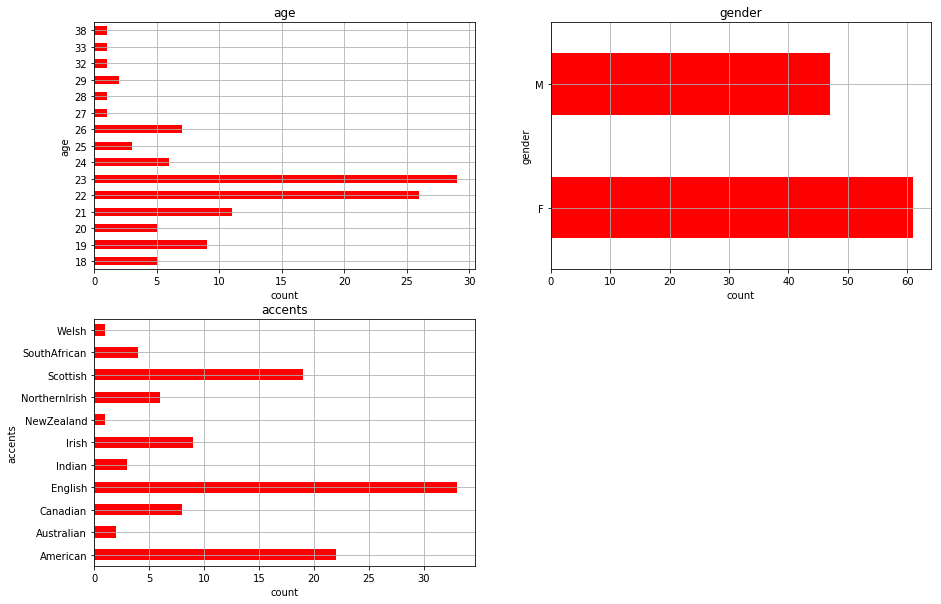

In [17]:
# plot descriptive statistics of speakers
plt.figure(figsize=(15,10))

for i, c in enumerate(['age', 'gender', 'accents']):
    plt.subplot(2,2,i+1)
    speaker_info[c].value_counts().sort_index().plot(kind='barh', color='red', grid=True, title=c)
    plt.xlabel('count')
    plt.ylabel(c)

In [69]:
display(speaker_info.iloc[10:25])

# set speaker here
speaker_id = 301

id  age gender        accents            region
236  236   23      F        English        Manchester
237  237   22      M       Scottish              Fife
238  238   22      F  NorthernIrish           Belfast
239  239   22      F        English        SW England
240  240   21      F        English  Southern England
241  241   21      M       Scottish             Perth
243  243   22      M        English            London
244  244   22      F        English        Manchester
245  245   25      M          Irish            Dublin
246  246   22      M       Scottish           Selkirk
247  247   22      M       Scottish            Argyll
248  248   23      F         Indian                  
249  249   22      F       Scottish          Aberdeen
250  250   22      F        English        SE England
251  251   26      M         Indian

In [19]:
txt_folder = os.path.join(vctk_folder, 'txt/p' + str(speaker_id))
txt_files = sorted(gl.glob(os.path.join(txt_folder, '*.txt')))

s = []
for t in txt_files:
    f = open(t, 'r')
    s.append(os.path.basename(t).replace('.txt', '') + ': ' + f.read())
    #s.append(f.read())
    #print f.read()
    f.close()

In [70]:
#pd.DataFrame(s, [os.path.basename(t).replace('.txt', '') for t in txt_files])
display(s)

# set sample here
sample_id = 102

['p301_001: Please call Stella.',
 'p301_002: Ask her to bring these things with her from the store.',
 'p301_003: Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.',
 'p301_004: We also need a small plastic snake and a big toy frog for the kids.',
 'p301_005: She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.',
 'p301_006: When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow.',
 'p301_007: The rainbow is a division of white light into many beautiful colors.',
 'p301_008: These take the shape of a long round arch, with its path high above, and its two ends apparently beyond the horizon.',
 'p301_009: There is , according to legend, a boiling pot of gold at one end.',
 'p301_010: People look, but no one ever finds it.',
 'p301_011: When a man looks for something beyond his reach, his friends say he is looking for the pot of gold at the end of the ra

id  age gender   accents          region
301  301   23      F  American  North Carolina

I am sure all schools would accept that.


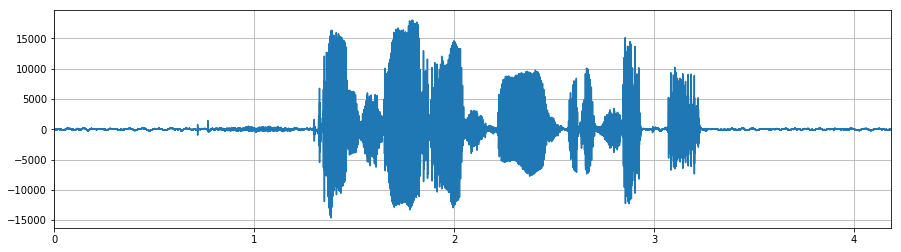

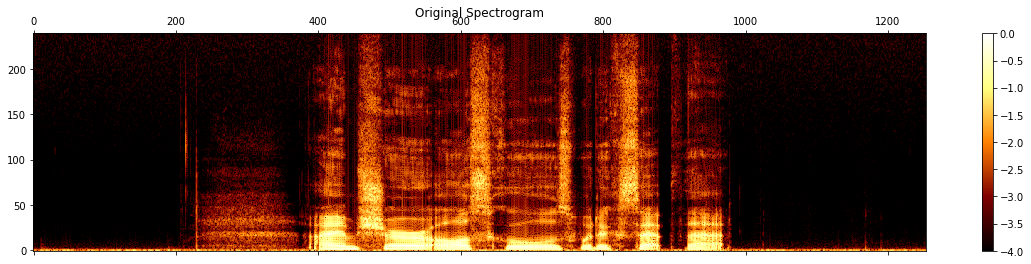

In [71]:
display_vctk_sample(speaker_id, sample_id)

In [22]:
# VoiceLoop only uses the speakers with American accents
speaker_info[speaker_info.accents == 'American']

id  age gender   accents          region
294  294   33      F  American   San Francisco
297  297   20      F  American        New York
299  299   25      F  American      California
300  300   23      F  American      California
301  301   23      F  American  North Carolina
305  305   19      F  American    Philadelphia
306  306   21      F  American        New York
308  308   18      F  American         Alabama
310  310   21      F  American       Tennessee
311  311   21      M  American            Iowa
315  315   18      M  American     New England
318  318   32      F  American            Napa
329  329   23      F  American                
330  330   26      F  American                
333  333   19      F  American         Indiana
334  334   18      M  American         Chicago
339  339   21      F  American    Pennsylvania
341  341   26      F  American            Ohio
345  345   22      M  American         Florida
360  360   19      M  American      New Jersey
361  361   19      F  American      New Jersey
362  362   29      F  American

- quick descriptive stats
- show example of labels, say we can use these
- show some examples

In [23]:
speaker_id = 301
sample_id = 117
# load pre-calculated WORLD features
feats = load_pre_calc_features(speaker_id, sample_id)

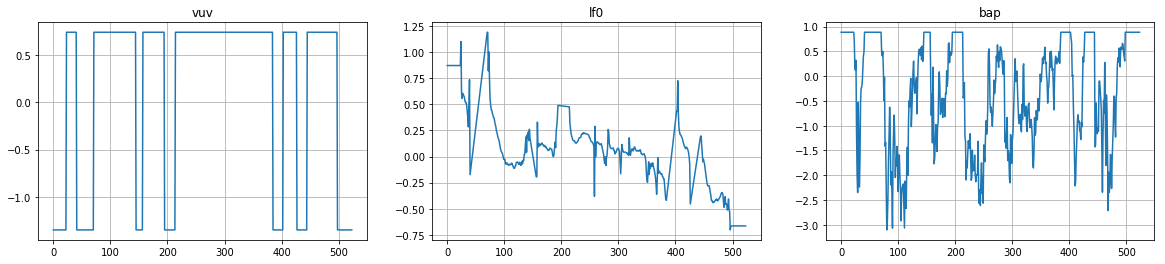

In [72]:
plot_lf0_etc(feats)

#### Original VCTK Sample

In [93]:
speaker_id = 301
sample_id = 112

play_vctk_sample(speaker_id, sample_id)

id  age gender   accents          region
301  301   23      F  American  North Carolina

And that is our first victory in Edinburgh.
ae n d dh ae t ih z aw er f er s t v ih k t er iy pau ih n eh d ah n b ax r ow


#### Synthesized Voice Using WORLD Features

In [94]:
# load pre-calculated WORLD features
feats = load_pre_calc_features(speaker_id, sample_id)
    
# synthesize sample from features and listen to the resulting .wav file
rate_synth, wav_data_synth = play_synthesized_features(feats)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete test.wav.wav.


## Benchmark VoiceLoop Results

In [27]:
speaker_list_vctk = [294, 297, 299, 300, 301, 305, 306, 308, 310, 311, 318, 329, 330, 333, 334, 339, 341, 345, 360, 361, 362]
speaker_lookup = dict([(x, y) for x, y in enumerate(speaker_list_vctk)])

In [28]:
def get_npz_file(loop_speaker_id, sample_id):
    # Lookup dict from VCTK speaker IDs to the IDs used inside VoiceLoop
    # should really pick this up from the checkpoints, but it's convenient to have it available before/without a checkpoint being defined
    speaker_list_vctk = [294, 297, 299, 300, 301, 305, 306, 308, 310, 311, 318, 329, 330, 333, 334, 339, 341, 345, 360, 361, 362]
    speaker_lookup = dict([(x, y) for x, y in enumerate(speaker_list_vctk)])

    # load VCTK speaker_info metadata
    speaker_info = get_vtck_speaker_info()
    #speaker_info[speaker_info.id.isin(speaker_lookup.values())]
    tmp = pd.DataFrame.from_dict(speaker_lookup, orient='index', columns=['id'])
    #pd.merge(speaker_info, tmp)

    vctk_source_speaker_id = int(speaker_lookup[loop_speaker_id])
    npz_file= 'p' + str(vctk_source_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz'

    # display/listen to the VCTK sample
    #print "Original VCTK .wav File"
    #play_vctk_sample(vctk_source_speaker_id, sample_id)
    
    return npz_file

In [29]:
def play_vctk_version_loop_id(loop_speaker_id, sample_id):
    # Lookup dict from VCTK speaker IDs to the IDs used inside VoiceLoop
    # should really pick this up from the checkpoints, but it's convenient to have it available before/without a checkpoint being defined
    speaker_list_vctk = [294, 297, 299, 300, 301, 305, 306, 308, 310, 311, 318, 329, 330, 333, 334, 339, 341, 345, 360, 361, 362]
    speaker_lookup = dict([(x, y) for x, y in enumerate(speaker_list_vctk)])

    # load VCTK speaker_info metadata
    speaker_info = get_vtck_speaker_info()
    #speaker_info[speaker_info.id.isin(speaker_lookup.values())]
    tmp = pd.DataFrame.from_dict(speaker_lookup, orient='index', columns=['id'])
    #pd.merge(speaker_info, tmp)

    vctk_source_speaker_id = int(speaker_lookup[loop_speaker_id])
    npz_file= 'p' + str(vctk_source_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz'

    # display/listen to the VCTK sample
    print "Original VCTK .wav File"
    play_vctk_sample(vctk_source_speaker_id, sample_id)
    return npz_file

#### Generate samples from a model checkpoint...

In [88]:
# generate based on an existing VCTK sample
source_speaker_id = 12
sample_id = 230
text = ''

# speaker id to use for VoiceLoop generation
gen_speaker_id = 9



# model checkpoint
checkpoint = 'checkpoints/vctk-rs/bestmodel.pth'
checkpoint = 'checkpoints/vctk-recover/bestmodel.pth'
checkpoint = 'models/vctk/bestmodel.pth'

output_dir = './'
output_file = 'test.wav'
norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
speaker_info[speaker_info.id==[speaker_lookup[gen_speaker_id]]]

# generate the sample
npz_file =  get_npz_file(source_speaker_id, sample_id)
loop_dict = generate_sample_with_loop(spkr_id=gen_speaker_id, npz=npz_file, text=text, checkpoint=checkpoint)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230_9.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.


#### 1) Original VCTK sample

In [96]:
npz_file = play_vctk_version_loop_id(source_speaker_id, sample_id)

Original VCTK .wav File


id  age gender   accents region
330  330   26      F  American

Wallace was in at the deep end.
ae n d dh ae t ih z aw er f er s t v ih k t er iy pau ih n eh d ah n b ax r ow


#### 2) WORLD Features

In [97]:
# Play WORLD version
IPython.display.display(Audio(loop_dict['output_orig_fname'] + '.wav', autoplay=True))

#### 3) VoiceLoop Version

In [98]:
# listen to sample synthesized from VoiceLoop features
Audio(loop_dict['output_file'] + '.wav', autoplay=True)

## Scottish Dataset
* Trained on just the 19 Scottish speakers

In [80]:
speaker_info[speaker_info.accents == 'Scottish']

id  age gender   accents         region
234  234   22      F  Scottish  West Dumfries
237  237   22      M  Scottish           Fife
241  241   21      M  Scottish          Perth
246  246   22      M  Scottish        Selkirk
247  247   22      M  Scottish         Argyll
249  249   22      F  Scottish       Aberdeen
252  252   22      M  Scottish      Edinburgh
255  255   19      M  Scottish       Galloway
260  260   21      M  Scottish         Orkney
262  262   23      F  Scottish      Edinburgh
263  263   22      M  Scottish       Aberdeen
264  264   23      F  Scottish   West Lothian
265  265   23      F  Scottish           Ross
271  271   19      M  Scottish           Fife
272  272   23      M  Scottish      Edinburgh
275  275   23      M  Scottish     Midlothian
281  281   29      M  Scottish      Edinburgh
284  284   20      M  Scottish           Fife
285  285   21      M  Scottish      Edinburgh

In [36]:
#loss, workings_early = el.eval_loss(checkpoint='checkpoints/vctk-rs/bestmodel.pth')
#loss, workings_early = el.eval_loss(checkpoint='checkpoints/vctk-16khz-cmu-no-boundaries-us/bestmodel.pth', data='data/vctk-16khz-cmu-no-boundaries-us')
loss, workings_early = el.eval_loss(checkpoint='checkpoints/vctk-16khz-cmu-no-boundaries-sc/bestmodel.pth', data='data/vctk-16khz-cmu-no-boundaries-sc')

Calculating loss:   0%|          | 0/12 [00:00<?, ?it/s]

checkpoints/vctk-16khz-cmu-no-boundaries-sc/bestmodel.pth
/home/ubuntu/loop
Namespace(K=10, attention_alignment=0.05, batch_size=64, checkpoint='checkpoints/vctk-16khz-cmu-no-boundaries-sc/bestmodel.pth', clip_grad=0.5, data='data/vctk-16khz-cmu-no-boundaries-sc', epochs=90, expName='checkpoints/vctk-16khz-cmu-no-boundaries-sc', gpu=0, hidden_size=256, hidden_size_speakers=256, ignore_grad=10000.0, lr=0.0001, max_seq_len=1000, mem_size=20, noise=0, nspk=22, output_size=63, seed=1, seq_len=100, visualize=False, vocabulary_size=44)


Loss 39.09: 100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


38.8418680827
38.8418696721


In [40]:
workings = workings_early

In [41]:
npz_map = map_original_npz_files(workings, data='data/vctk-16khz-cmu-no-boundaries-sc')

no match: 14
no match: 84
no match: 141
no match: 192
no match: 195
no match: 200
no match: 229
no match: 236
no match: 271
no match: 276
no match: 303
no match: 308
no match: 357
no match: 366
no match: 384
no match: 394
no match: 402
no match: 406
no match: 433
no match: 435
no match: 451
no match: 471


In [105]:
## Choose a sample from the validation set
idx = 138
idx = 55
idx = 271
idx = 192
#idx = 250

In [55]:
def display_vctk_sample_for_idx(idx):
    vctk_raw_folder = '/home/ubuntu/VCTK-Corpus/'
    vctk_prebuilt_folder = '/home/ubuntu/vctk-16khz-cmu-no-boundaries/'
    speaker_info = get_vtck_speaker_info()
    idx_spkr = int(os.path.basename(npz_map[idx][1]).split('_')[0][1:])
    idx_sample = int(os.path.basename(npz_map[idx][1]).split('_')[1][:-4])
    display_vctk_sample(idx_spkr, idx_sample)

id  age gender   accents region
284  284   20      M  Scottish   Fife

That was the lesson to be learned from the European Championships.



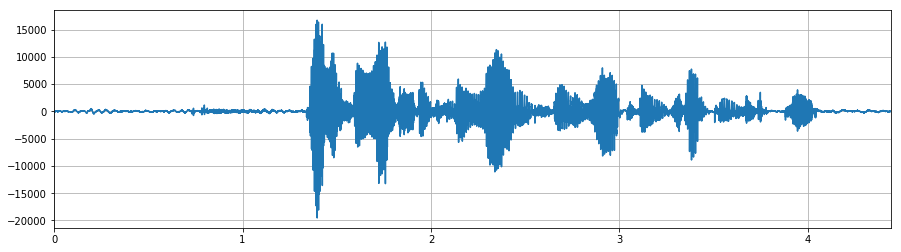

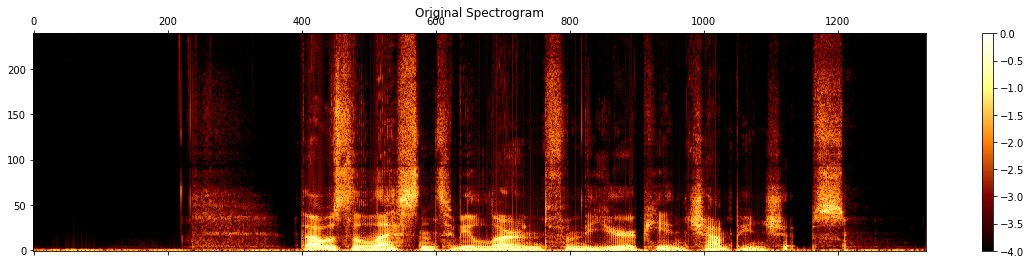

In [106]:
display_vctk_sample_for_idx(idx)

#### Synthesized from World Features

In [101]:
#### Synthesized from Ground Truth Features
generate_merlin_wav(workings['target_feat'][idx, :workings['target_len'][idx], :],
                    '',
                    'tst',
                    '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-sc/norm_info/norm.dat')

Audio('tst' + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete tst.wav.


#### Synthesized from VoiceLoop Outputs

In [107]:
#### Synthesized from Output Features
generate_merlin_wav(workings['output'][idx, :, :],
                    '',
                    'tst',
                    '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-sc/norm_info/norm.dat')

Audio('tst' + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete tst.wav.


## Features: VoiceLoop vs. Ground Truth

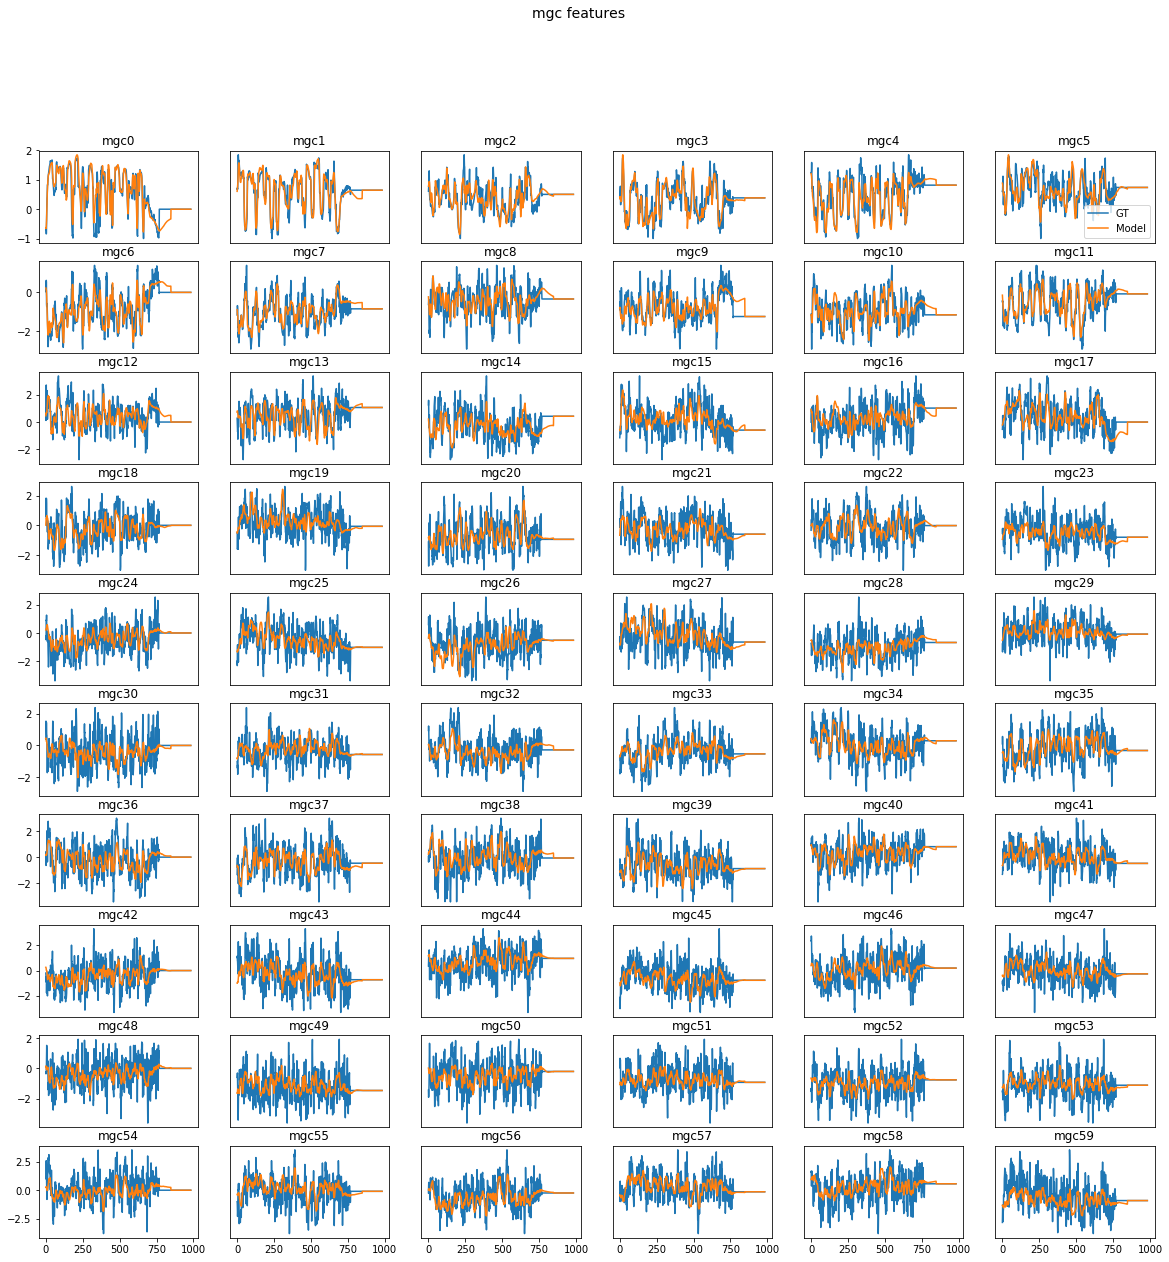

In [103]:
plot_mgc_feature_comparison(workings['target_feat'][idx,:,:], workings['output'][idx,:,:], label_a='GT', label_b='Model')

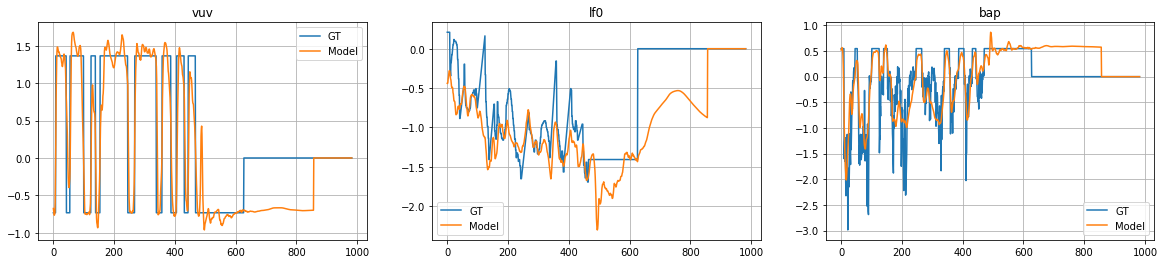

In [50]:
plot_other_feature_comparison(workings['target_feat'][idx,:,:], workings['output'][idx,:,:], label_a='GT', label_b='Model')